# Analyze Images with Azure AI Vision
Azure AI Vision is an artificial intelligence capability that enables software systems to interpret visual input by analyzing images. In Microsoft Azure, the Vision Azure AI service provides pre-built models for common computer vision tasks, including analysis of images to suggest captions and tags, detection of common objects, landmarks, celebrities, brands, and the presence of adult content. You can also use the Azure AI Vision service to analyze image color and formats, and to generate "smart-cropped" thumbnail images.

In [3]:
cog_endpoint="your_cognitive_services_endpoint"
cog_key="your_key"
cog_region = "eastus"

#### Prepare to use the Azure AI Vision SDK

In [1]:
!pip install azure-cognitiveservices-vision-computervision==0.7.0 --quiet

In [4]:
# import namespaces
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials
import matplotlib.pyplot as plt

## Analyze an image to suggest a caption

In [5]:
# Authenticate Azure AI Vision client
credential = CognitiveServicesCredentials(cog_key) 
cv_client = ComputerVisionClient(cog_endpoint, credential)

In [6]:
# Specify features to be retrieved
features = [VisualFeatureTypes.description,
            VisualFeatureTypes.tags,
            VisualFeatureTypes.categories,
            VisualFeatureTypes.brands,
            VisualFeatureTypes.objects,
            VisualFeatureTypes.adult]

In [5]:
def display_image(path):
    import matplotlib.image as mpimg

    # Load the image
    img = mpimg.imread(path)

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Turn off the axis
    plt.show()

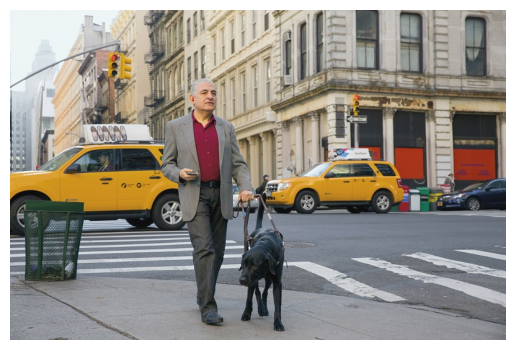

In [6]:
image_file = 'images/street.jpg'
display_image(image_file)

In [9]:
# Get image analysis
with open(image_file, mode="rb") as image_data:
    analysis = cv_client.analyze_image_in_stream(image_data , features)

# Get image description
for caption in analysis.description.captions:
    print("Description: '{}' (confidence: {:.2f}%)".format(caption.text, caption.confidence * 100))

Description: 'a person walking a dog on a sidewalk' (confidence: 46.96%)


* Observe the output, which should include a suggested caption for the street.jpg image.
* Run the program again, this time with the argument images/building.jpg to see the caption that gets generated for the building.jpg image.
* Repeat the previous step to generate a caption for the images/person.jpg file.

In [10]:
# Get image tags
if (len(analysis.tags) > 0):
    print("Tags: ")
    for tag in analysis.tags:
        print(" -'{}' (confidence: {:.2f}%)".format(tag.name, tag.confidence * 100))

Tags: 
 -'outdoor' (confidence: 99.98%)
 -'road' (confidence: 99.98%)
 -'building' (confidence: 99.92%)
 -'street' (confidence: 99.53%)
 -'land vehicle' (confidence: 93.68%)
 -'way' (confidence: 93.67%)
 -'dog' (confidence: 93.55%)
 -'vehicle' (confidence: 92.56%)
 -'car' (confidence: 91.38%)
 -'sidewalk' (confidence: 87.51%)
 -'city' (confidence: 86.10%)
 -'wheel' (confidence: 69.87%)
 -'people' (confidence: 65.72%)
 -'yellow' (confidence: 64.94%)
 -'carnivore' (confidence: 63.83%)
 -'taxi' (confidence: 60.63%)
 -'busy' (confidence: 30.32%)
 -'curb' (confidence: 7.65%)


In [11]:
# Get image categories
if (len(analysis.categories) > 0):
    print("Categories:")
    landmarks = []
    for category in analysis.categories:
        # Print the category
        print(" -'{}' (confidence: {:.2f}%)".format(category.name, category.score * 100))
        if category.detail:
            # Get landmarks in this category
            if category.detail.landmarks:
                for landmark in category.detail.landmarks:
                    if landmark not in landmarks:
                        landmarks.append(landmark)

    # If there were landmarks, list them
    if len(landmarks) > 0:
        print("Landmarks:")
        for landmark in landmarks:
            print(" -'{}' (confidence: {:.2f}%)".format(landmark.name, landmark.confidence * 100))


Categories:
 -'outdoor_' (confidence: 0.39%)
 -'outdoor_road' (confidence: 55.86%)


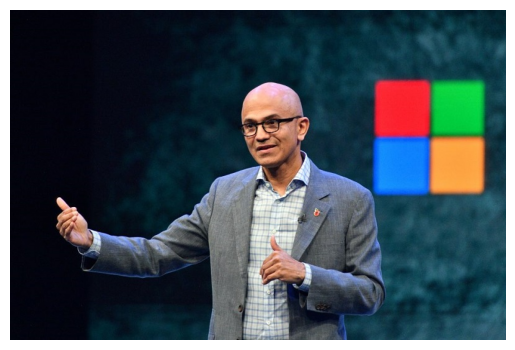

NameError: name 'cv_client' is not defined

In [7]:
image_file = 'images/person.jpg'
display_image(image_file)
# Get image analysis
with open(image_file, mode="rb") as image_data:
    analysis = cv_client.analyze_image_in_stream(image_data , features)

In [16]:
# Get brands in the image
if (len(analysis.brands) > 0):
    print("Brands: ")
    for brand in analysis.brands:
        print(" -'{}' (confidence: {:.2f}%)".format(brand.name, brand.confidence * 100))

Brands: 
 -'Microsoft' (confidence: 87.50%)


In [19]:
image_file = 'images/street.jpg'
display_image(image_file)
# Get image analysis
with open(image_file, mode="rb") as image_data:
    analysis = cv_client.analyze_image_in_stream(image_data , features)

In [23]:
from array import array
from PIL import Image, ImageDraw
import sys
import time
from matplotlib import pyplot as plt
import numpy as np

Objects in image:
 -building (confidence: 62.30%)
  Results saved in objects.jpg


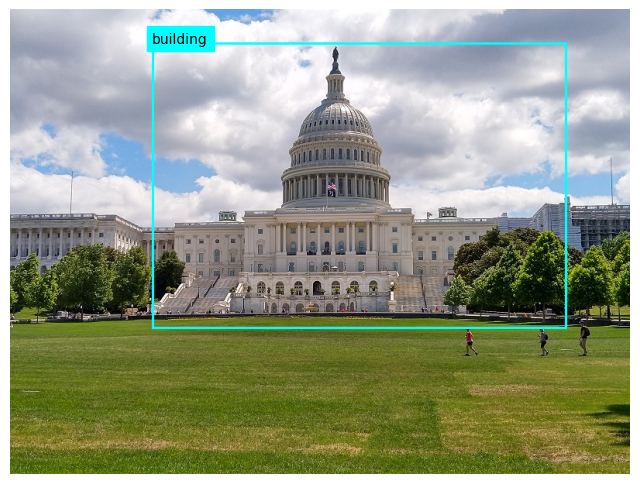

In [24]:
# Get objects in the image
if len(analysis.objects) > 0:
    print("Objects in image:")

    # Prepare image for drawing
    fig = plt.figure(figsize=(8, 8))
    plt.axis('off')
    image = Image.open(image_file)
    draw = ImageDraw.Draw(image)
    color = 'cyan'
    for detected_object in analysis.objects:
        # Print object name
        print(" -{} (confidence: {:.2f}%)".format(detected_object.object_property, detected_object.confidence * 100))
        
        # Draw object bounding box
        r = detected_object.rectangle
        bounding_box = ((r.x, r.y), (r.x + r.w, r.y + r.h))
        draw.rectangle(bounding_box, outline=color, width=3)
        plt.annotate(detected_object.object_property,(r.x, r.y), backgroundcolor=color)
    # Save annotated image
    plt.imshow(image)
    outputfile = 'objects.jpg'
    fig.savefig(outputfile)
    print('  Results saved in', outputfile)

In [25]:
# Get moderation ratings
ratings = 'Ratings:\n -Adult: {}\n -Racy: {}\n -Gore: {}'.format(analysis.adult.is_adult_content,
                                                                    analysis.adult.is_racy_content,
                                                                    analysis.adult.is_gory_content)
print(ratings)

Ratings:
 -Adult: False
 -Racy: False
 -Gore: False


In [26]:
# Generate a thumbnail
with open(image_file, mode="rb") as image_data:
    # Get thumbnail data
    thumbnail_stream = cv_client.generate_thumbnail_in_stream(100, 100, image_data, True)

# Save thumbnail image
thumbnail_file_name = 'thumbnail.png'
with open(thumbnail_file_name, "wb") as thumbnail_file:
    for chunk in thumbnail_stream:
        thumbnail_file.write(chunk)

print('Thumbnail saved in.', thumbnail_file_name)

Thumbnail saved in. thumbnail.png


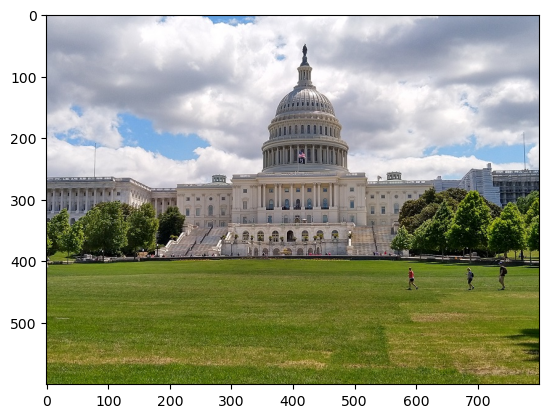

In [28]:
display_image(image_file)
display_image(thumbnail_file_name)